In [1]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs

assert torch.backends.mps.is_available(), \
"The current runtime does not have MPS support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [3]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys, ssl
    from urllib.request import urlretrieve

    ssl._create_default_https_context = ssl._create_unverified_context
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)

    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write(f'Downlaoding {model_dir} {cached_file}')
            urlretrieve(url, cached_file)
        return cached_file
    except:
        # remove lock file so download can be executed next time
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write(f'Failed to download {url}')
                  

In [4]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x

In [5]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [6]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [7]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

In [8]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)

def get_sparsity(tensor: torch.Tensor) -> float:
    return 1- float(tensor.count_nonzero())/tensor.numel()

def get_model_sparsity(model: nn.Module) -> float:
    num_nonzeros, num_ele = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_ele += param.numel()
    return 1 - float(num_nonzeros/num_ele)

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements

def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [ ]:
### Define misc for verification

In [9]:
def test_fine_grained_prune(test_tensor=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]), 
                           test_mask=torch.tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]), 
                           target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for j in range(tensor.shape[1]):
            for i in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                               ha='center',va='center', color='k')
    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1, 2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense_tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')    
        
        

#test_fine_grained_prune()
### Load the pre-trained model and CIFAR-10 dataset

In [36]:
checkpoint_url = "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
checkpoint = torch.load(download_url(checkpoint_url), map_location='cpu', weights_only=True)


model = VGG().to(device)
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda: model.load_state_dict(checkpoint['state_dict'])

In [11]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

Files already downloaded and verified
Files already downloaded and verified


### Verify the accuracy and model size

In [12]:
default_model_accuracy = evaluate(model, dataloader['test'])
default_model_size = get_model_size(model)

print(f'Model accuracy: {default_model_accuracy:.2f}, model size: {default_model_size/MiB:.2f}')

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Model accuracy: 92.95, model size: 35.20


### Vis weight distribution

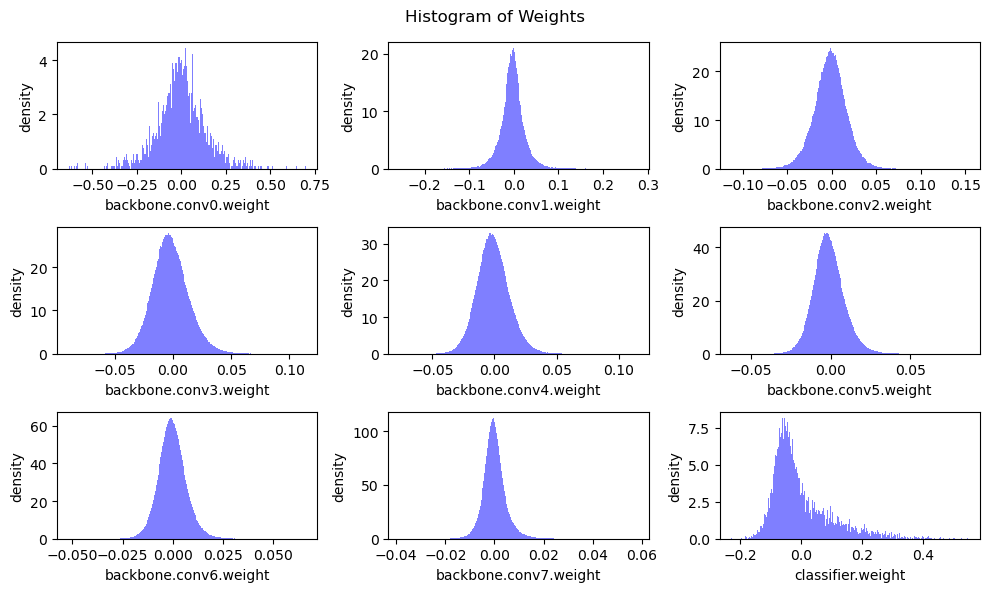

In [13]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True, color='blue', alpha=0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True, color='blue', alpha=0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

### Question 2 (15 pts)

Please complete the following magnitude-based fine-grained pruning function.

**Hint**:
*   In step 1, we calculate the number of zeros (`num_zeros`) after pruning. Note that `num_zeros` should be an integer. You could use either `round()` or `int()` to convert a floating number into an integer. Here we use `round()`.
*   In step 2, we calculate the `importance` of weight tensor. Pytorch provides [`torch.abs()`](https://pytorch.org/docs/stable/generated/torch.abs.html#torch.abs), [`torch.Tensor.abs()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs.html#torch.Tensor.abs), [`torch.Tensor.abs_()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs_.html) APIs.
*   In step 3, we calculate the pruning `threshold` so that all synapses with importance smaller than `threshold` will be removed. Pytorch provides [`torch.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.kthvalue.html), [`torch.Tensor.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.Tensor.kthvalue.html), [`torch.topk()`](https://pytorch.org/docs/stable/generated/torch.topk.html) APIs.
*   In step 4, we calculate the pruning `mask` based on the `threshold`. **1** in the `mask` indicates the synapse will be kept, and **0** in the `mask` indicates the synapse will be removed. `mask = importance > threshold`. Pytorch provides [`torch.gt()`](https://pytorch.org/docs/stable/generated/torch.gt.html?highlight=torch%20gt#torch.gt) API.

In [55]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    ##################### YOUR CODE STARTS HERE #####################
    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(tensor.numel()*sparsity)
    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)
    # Step 3: calculate the pruning threshold. 
    threshold = torch.kthvalue(importance.view(-1).cpu(), num_zeros).values.to(device).item() # torch.kthvalue is not supported in mps
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = (importance > threshold)
    ##################### YOUR CODE ENDS HERE #######################

    # Step 5: apply mask to prune the tensor
    # print(f"debug: {tensor.device}, {mask.device}")
    tensor.mul_(mask)

    return mask

debug: cpu, cpu


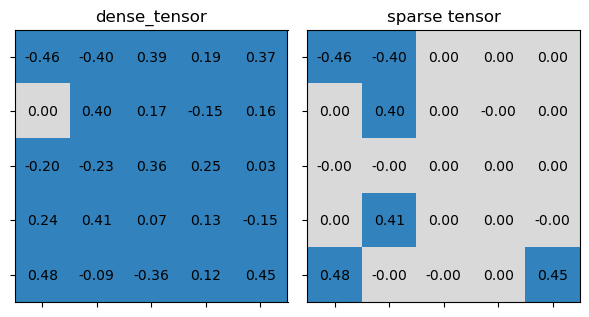

* Test fine_grained_prune()
    target sparsity: 0.75
        sparsity before pruning: 0.04
        sparsity after pruning: 0.76
        sparsity of pruning mask: 0.76
* Test passed.


In [24]:
test_fine_grained_prune()

# Q3:
The last cell plots the tensor before and after pruning. Nonzeros are rendered in blue while zeros are rendered in gray. Please modify the value of `target_sparsity` in the following code cell so that there are only 10 nonzeros in the sparse tensor after pruning.

debug: cpu, cpu


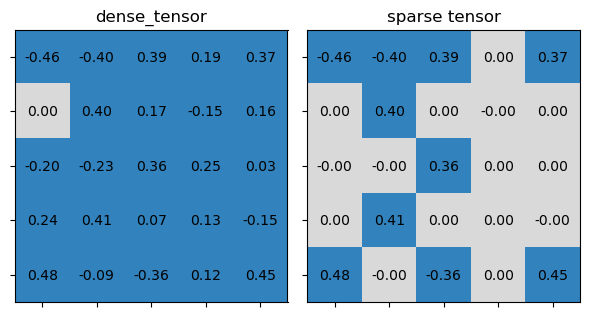

* Test fine_grained_prune()
    target sparsity: 0.60
        sparsity before pruning: 0.04
        sparsity after pruning: 0.60
        sparsity of pruning mask: 0.60
* Test passed.


In [25]:
##################### YOUR CODE STARTS HERE #####################
target_sparsity = 1- 10/(5*5) # please modify the value of target_sparsity
##################### YOUR CODE ENDS HERE #####################
test_fine_grained_prune(target_sparsity=target_sparsity, target_nonzeros=10)

We now wrap the fine-grained pruning function into a class for pruning the whole model. In class FineGrainedPruner, we have to keep a record of the pruning masks so that we could apply the masks whenever the model weights change to make sure the model keep sparse all the time.

### Sensitivity scan

Different layers contribute differently to the model performance. It is challenging to decide the proper sparsity for each layer. A widely used approach is sensitivity scan.

During the sensitivity scan, at each time, we will only prune one layer to see the accuracy degradation. By scanning different sparsities, we could draw the sensitivity curve (i.e., accuracy vs. sparsity) of the corresponding layer.

Here is an example figure for sensitivity curves. The x-axis is the sparsity or the percentage of #parameters dropped (i.e., sparsity). The y-axis is the validation accuracy. (This is Figure 6 in Learning both Weights and Connections for Efficient Neural Networks)

The following code cell defines the sensitivity scan function that returns the sparsities scanned, and a list of accuracies for each weight to be pruned.


In [52]:
import typing as t

class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict:t.Dict[str, float]):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # only for conv and FC
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks        
    

In [47]:
help(FineGrainedPruner)

Help on class FineGrainedPruner in module __main__:

class FineGrainedPruner(builtins.object)
 |  FineGrainedPruner(model, sparsity_dict)
 |
 |  Methods defined here:
 |
 |  __init__(self, model, sparsity_dict)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  apply(self, model)
 |
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |
 |  prune(model, sparsity_dict: Dict[str, float])
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object



In [42]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, step=0.1, start=0.4, stop=1.0, verbose=True):
    sparsities = np.arange(start, stop, step)
    accuracies = []

    named_weights = [(name, param) for (name, param) in model.named_parameters() if param.dim() > 1]

    for i, (name, param) in enumerate(named_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i}/{len(named_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'sparsity={sparsity:.2f}: accuracy={acc:.2f}%')
            # restore weight
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies          
    
    

In [ ]:
NotImplementedError: The operator 'aten::kthvalue.values' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [29]:
sparsities, accuracies = sensitivity_scan(model, dataloader['test'], step=0.1, start=0.4, stop=1.0)

scanning 0/9 weight - backbone.conv0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

debug: mps:0, mps:0
sparsity=0.40: accuracy=92.42%
debug: mps:0, mps:0
sparsity=0.50: accuracy=91.19%
debug: mps:0, mps:0
sparsity=0.60: accuracy=87.55%
debug: mps:0, mps:0
sparsity=0.70: accuracy=83.39%
debug: mps:0, mps:0
sparsity=0.80: accuracy=69.41%
debug: mps:0, mps:0
sparsity=0.90: accuracy=31.81%
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.42%, 91.19%, 87.55%, 83.39%, 69.41%, 31.81%]

scanning 1/9 weight - backbone.conv1.weight:   0%|          | 0/6 [00:00<?, ?it/s]

debug: mps:0, mps:0
sparsity=0.40: accuracy=92.93%
debug: mps:0, mps:0
sparsity=0.50: accuracy=92.88%
debug: mps:0, mps:0
sparsity=0.60: accuracy=92.71%
debug: mps:0, mps:0
sparsity=0.70: accuracy=92.40%
debug: mps:0, mps:0
sparsity=0.80: accuracy=91.32%
debug: mps:0, mps:0
sparsity=0.90: accuracy=84.78%
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.93%, 92.88%, 92.71%, 92.40%, 91.32%, 84.78%]

scanning 2/9 weight - backbone.conv2.weight:   0%|          | 0/6 [00:00<?, ?it/s]

debug: mps:0, mps:0
sparsity=0.40: accuracy=92.94%
debug: mps:0, mps:0
sparsity=0.50: accuracy=92.64%
debug: mps:0, mps:0
sparsity=0.60: accuracy=92.46%
debug: mps:0, mps:0
sparsity=0.70: accuracy=91.77%
debug: mps:0, mps:0
sparsity=0.80: accuracy=89.85%
debug: mps:0, mps:0
sparsity=0.90: accuracy=78.56%
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.64%, 92.46%, 91.77%, 89.85%, 78.56%]

scanning 3/9 weight - backbone.conv3.weight:   0%|          | 0/6 [00:00<?, ?it/s]

debug: mps:0, mps:0
sparsity=0.40: accuracy=92.86%
debug: mps:0, mps:0
sparsity=0.50: accuracy=92.72%
debug: mps:0, mps:0
sparsity=0.60: accuracy=92.23%
debug: mps:0, mps:0
sparsity=0.70: accuracy=91.09%
debug: mps:0, mps:0
sparsity=0.80: accuracy=85.35%
debug: mps:0, mps:0
sparsity=0.90: accuracy=51.31%
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.86%, 92.72%, 92.23%, 91.09%, 85.35%, 51.31%]

scanning 4/9 weight - backbone.conv4.weight:   0%|          | 0/6 [00:00<?, ?it/s]

debug: mps:0, mps:0
sparsity=0.40: accuracy=92.88%
debug: mps:0, mps:0
sparsity=0.50: accuracy=92.68%
debug: mps:0, mps:0
sparsity=0.60: accuracy=92.22%
debug: mps:0, mps:0
sparsity=0.70: accuracy=89.47%
debug: mps:0, mps:0
sparsity=0.80: accuracy=76.87%
debug: mps:0, mps:0
sparsity=0.90: accuracy=38.78%
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.88%, 92.68%, 92.22%, 89.47%, 76.87%, 38.78%]

scanning 5/9 weight - backbone.conv5.weight:   0%|          | 0/6 [00:00<?, ?it/s]

debug: mps:0, mps:0
sparsity=0.40: accuracy=92.92%
debug: mps:0, mps:0
sparsity=0.50: accuracy=92.71%
debug: mps:0, mps:0
sparsity=0.60: accuracy=92.63%
debug: mps:0, mps:0
sparsity=0.70: accuracy=91.88%
debug: mps:0, mps:0
sparsity=0.80: accuracy=89.90%
debug: mps:0, mps:0
sparsity=0.90: accuracy=82.19%
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.92%, 92.71%, 92.63%, 91.88%, 89.90%, 82.19%]

scanning 6/9 weight - backbone.conv6.weight:   0%|          | 0/6 [00:00<?, ?it/s]

debug: mps:0, mps:0
sparsity=0.40: accuracy=92.94%
debug: mps:0, mps:0
sparsity=0.50: accuracy=92.86%
debug: mps:0, mps:0
sparsity=0.60: accuracy=92.65%
debug: mps:0, mps:0
sparsity=0.70: accuracy=92.10%
debug: mps:0, mps:0
sparsity=0.80: accuracy=90.58%
debug: mps:0, mps:0
sparsity=0.90: accuracy=83.65%
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.86%, 92.65%, 92.10%, 90.58%, 83.65%]

scanning 7/9 weight - backbone.conv7.weight:   0%|          | 0/6 [00:00<?, ?it/s]

debug: mps:0, mps:0
sparsity=0.40: accuracy=92.94%
debug: mps:0, mps:0
sparsity=0.50: accuracy=92.92%
debug: mps:0, mps:0
sparsity=0.60: accuracy=92.88%
debug: mps:0, mps:0
sparsity=0.70: accuracy=92.81%
debug: mps:0, mps:0
sparsity=0.80: accuracy=92.63%
debug: mps:0, mps:0
sparsity=0.90: accuracy=91.34%
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.92%, 92.88%, 92.81%, 92.63%, 91.34%]

scanning 8/9 weight - classifier.weight:   0%|          | 0/6 [00:00<?, ?it/s]

debug: mps:0, mps:0
sparsity=0.40: accuracy=92.91%
debug: mps:0, mps:0
sparsity=0.50: accuracy=92.83%
debug: mps:0, mps:0
sparsity=0.60: accuracy=92.81%
debug: mps:0, mps:0
sparsity=0.70: accuracy=92.97%
debug: mps:0, mps:0
sparsity=0.80: accuracy=92.68%
debug: mps:0, mps:0
sparsity=0.90: accuracy=92.52%
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.91%, 92.83%, 92.81%, 92.97%, 92.68%, 92.52%]

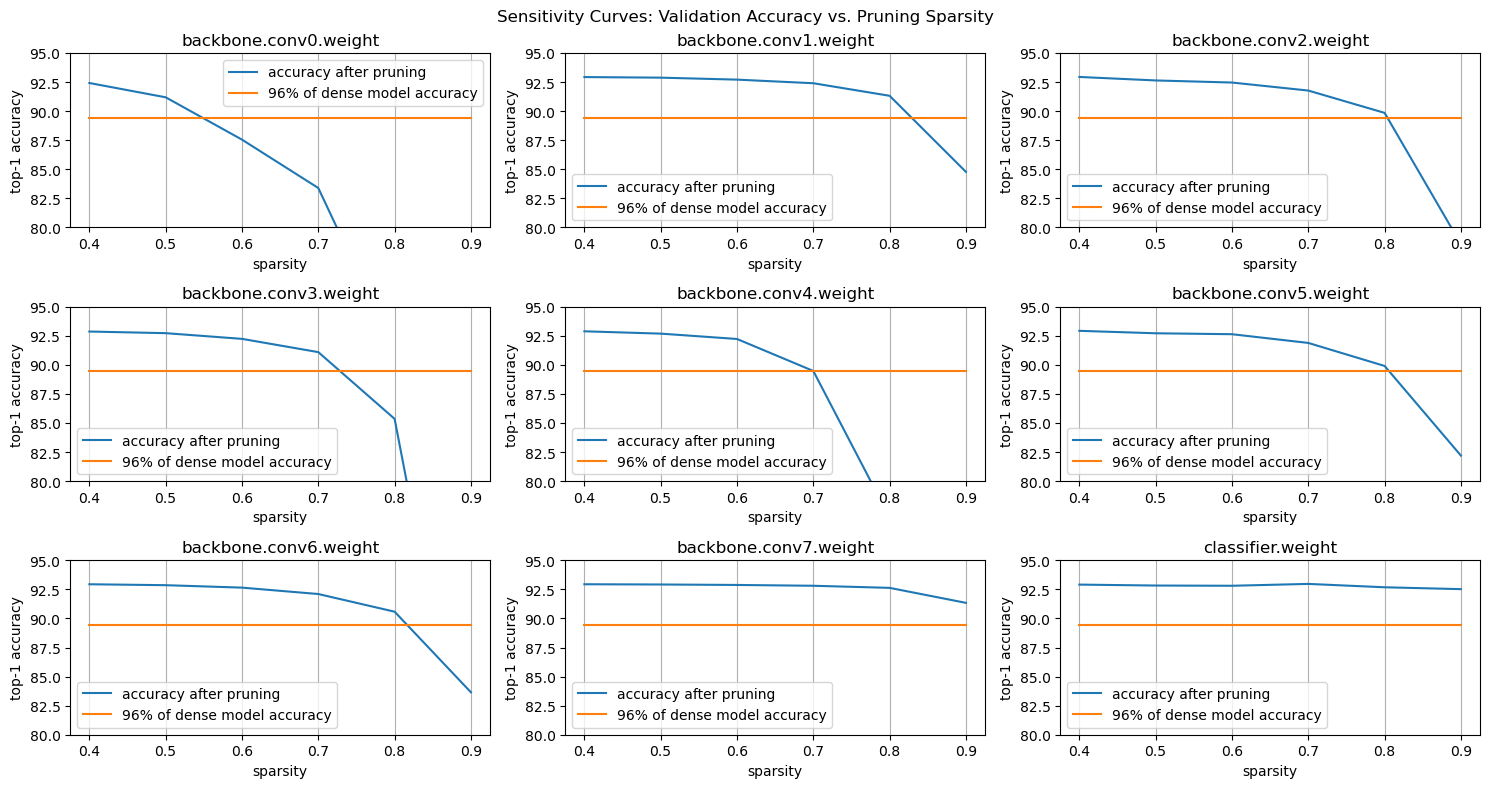

In [35]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)),figsize=(15,8))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            ax.set_ylim(80, 95)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, default_model_accuracy)

Q4.1 What's the relationship between pruning sparsity and model accuracy? (i.e., does accuracy increase or decrease when sparsity becomes higher?)

The accuracy decrease when the sparsity becomes higher

Q4.2 Do all the layers have the same sensitivity? Which layer is the most sensitive to the pruning sparsity?

No, different layers have different sensitivities. The conv0 layer is the most sensitive to sparsity 

## \#Parameters of each layer
In addition to accuracy, the number of each layer's parameters also affects the decision on sparsity selection. Layers with more #parameters require larger sparsities.

Please run the following code cell to plot the distribution of #parameters in the whole model.

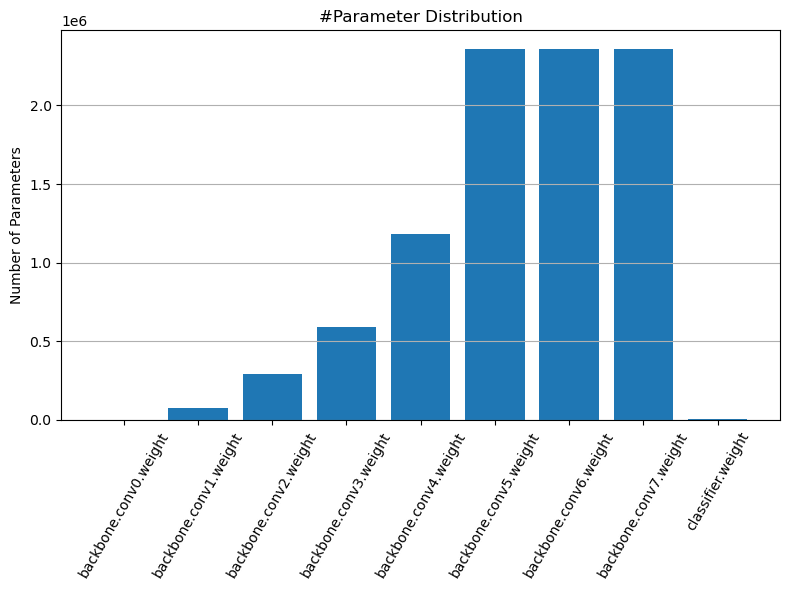

In [31]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

## Select Sparsity Based on Sensitivity Curves and \#Parameters Distribution

### Question 5 (10 pts)

Based on the sensitivity curves and the distribution of #parameters in the model, please select the sparsity for each layer.

Note that the overall compression ratio of pruned model mostly depends on the layers with larger #parameters, and different layers have different sensitivity to pruning (see Question 4).

Please make sure that after pruning, the sparse model is 25% of the size of the dense model, and validation accuracy is higher than 92.5 after finetuning.

**Hint**:
*   The layer with more #parameters should have larger sparsity. (see *Figure #Parameter Distribution*)
*   The layer that is sensitive to the pruning sparsity (i.e., the accuracy will drop quickly as sparsity becomes higher) should have smaller sparsity. (see *Figure Sensitivity Curves*)

In [38]:
recover_model()

<All keys matched successfully>

In [61]:
recover_model()

sparsity_dict = {
##################### YOUR CODE STARTS HERE #####################
    # please modify the sparsity value of each layer
    # please DO NOT modify the key of sparsity_dict
    'backbone.conv0.weight': 0.5,
    'backbone.conv1.weight': 0.65,
    'backbone.conv2.weight': 0.65,
    'backbone.conv3.weight': 0.65,
    'backbone.conv4.weight': 0.7,
    'backbone.conv5.weight': 0.77,
    'backbone.conv6.weight': 0.77,
    'backbone.conv7.weight': 0.8,
    'classifier.weight': 0.7
##################### YOUR CODE ENDS HERE #######################
}

Please run the following cell to prune the model according to your defined `sparsity_dict`, and print the information of sparse model.

After pruning with sparsity dictionary
  backbone.conv0.weight: 0.50
  backbone.conv1.weight: 0.65
  backbone.conv2.weight: 0.65
  backbone.conv3.weight: 0.65
  backbone.conv4.weight: 0.70
  backbone.conv5.weight: 0.77
  backbone.conv6.weight: 0.77
  backbone.conv7.weight: 0.80
  classifier.weight: 0.70
The sparsity of each layer becomes
  backbone.conv0.weight: 0.50
  backbone.conv1.weight: 0.65
  backbone.conv2.weight: 0.65
  backbone.conv3.weight: 0.65
  backbone.conv4.weight: 0.70
  backbone.conv5.weight: 0.77
  backbone.conv6.weight: 0.77
  backbone.conv7.weight: 0.80
  classifier.weight: 0.70
Sparse model has size=8.60 MiB = 24.43% of dense model size


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=84.49% before fintuning


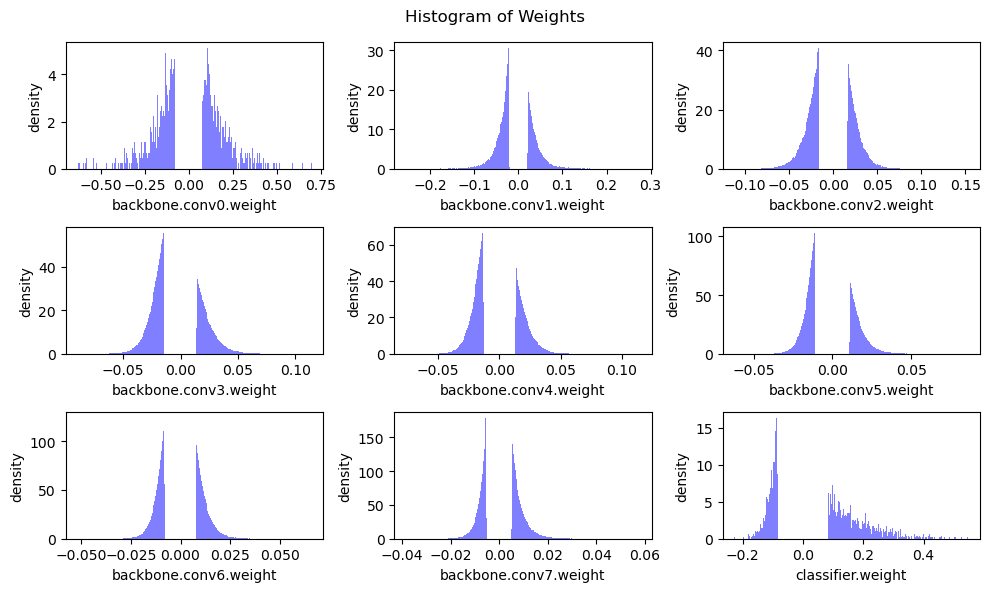

In [62]:
pruner = FineGrainedPruner(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / default_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

plot_weight_distribution(model, count_nonzero_only=True)

## Finetune the fine-grained pruned model



As we can see from the outputs of previous cell, even though fine-grained pruning reduces the most of model weights, the accuracy of model also dropped. Therefore, we have to finetune the sparse model to recover the accuracy.

Please run the following cell to finetune the sparse model. It should take around 3 minutes to finish.


In [145]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')
    

Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 1 Accuracy 92.50% / Best Accuracy: 92.50%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 2 Accuracy 92.62% / Best Accuracy: 92.62%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 3 Accuracy 92.70% / Best Accuracy: 92.70%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 4 Accuracy 92.56% / Best Accuracy: 92.70%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 5 Accuracy 92.76% / Best Accuracy: 92.76%


Run the following cell to see the information of best finetuned sparse model.

In [146]:
# load the best sparse model checkpoint to evaluate the final performance
model.load_state_dict(best_sparse_model_checkpoint['state_dict'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / default_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")

Sparse model has size=8.60 MiB = 24.43% of dense model size


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=92.76% after fintuning


# Channel Pruning

In [78]:
# firstly, let's restore the model weights to the original dense version
#   and check the validation accuracy
recover_model()
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%


## Remove Channel Weights

Unlike fine-grained pruning, we can remove the weights entirely from the tensor in channel pruning. That is to say, the number of output channels is reduced:

> $\#\mathrm{out\_channels}_{\mathrm{new}} = \#\mathrm{out\_channels}_{\mathrm{origin}} \cdot (1 - \mathrm{sparsity})$

The weight tensor $W$ is still dense after channel pruning. Thus, we will refer to *sparsity* as ***prune ratio***.

Like fine-grained pruning, we can use different pruning rates for different layers. However, we use a uniform pruning rate for all the layers for now. We are targeting 2x computation reduction, which is roughly 30% uniform pruning rate (think about why).

Feel free to try out different pruning ratios per layer at the end of this section. You can pass in a list of ratios to the `channel_prune` function.

### Question 6 (10 pts)

Please complete the following functions for channel pruning.

Here we naively prune all output channels other than the first $\#\mathrm{out\_channels}_{\mathrm{new}}$ channels.

In [110]:
def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    """A function to calculate the number of layers to PRESERVE after pruning
    Note that preserve_rate = 1. - prune_ratio
    """
    ##################### YOUR CODE STARTS HERE #####################
    return round((1.0 - prune_ratio) * channels)
    ##################### YOUR CODE ENDS HERE #####################

@torch.no_grad()
def channel_prune(model: nn.Module,
                  prune_ratio: Union[List, float]) -> nn.Module:
    """Apply channel pruning to each of the conv layer in the backbone
    Note that for prune_ratio, we can either provide a floating-point number,
    indicating that we use a uniform pruning rate for all layers, or a list of
    numbers to indicate per-layer pruning rate.
    """
    assert isinstance(prune_ratio, (float, list))
    n_conv = len([m for m in model.backbone if isinstance(m, nn.Conv2d)])
    
    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv -1
    else:
        prune_ratio = [prune_ratio] * (n_conv - 1)

    model = copy.deepcopy(model)
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]

    # for i, m in enumerate(all_convs):
    #     if i != 0:
    #         print(f"prev conv dim: {all_convs[i-1].weight.shape})")
    #         print(f"cur. conv dim: {m.weight.shape}\n")

    # apply prunning. we naively keep the first k channels ?
    assert len(all_convs) == len(all_bns)
    for i_ratio, p_ratio in enumerate(prune_ratio):
        prev_conv = all_convs[i_ratio]
        prev_bn = all_bns[i_ratio]
        next_conv = all_convs[i_ratio+1]
        n_channels = prev_conv.out_channels # same as next_conv.in_channels
        n_keep = get_num_channels_to_keep(n_channels, p_ratio)

        #print(n_channels, n_keep)

        # prune the output of prev. conv and bn
        prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
        prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
        prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
        prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
        prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])

        # prune the input of the next conv (hint: just one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.set_(next_conv.weight.detach()[:,:n_keep,:,:]) # update input channel num
        ##################### YOUR CODE ENDS HERE ##################### 
    
    return model

Run the following cell to perform a sanity check to make sure the implementation is correct.

In [111]:
dummy_input = torch.randn(1, 3, 32, 32).to(device)
pruned_model = channel_prune(model, prune_ratio=0.3)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print(pruned_macs)
assert pruned_macs == 305388064
print('* Check passed. Right MACs for the pruned model.')

305388064
* Check passed. Right MACs for the pruned model.




Now let's evaluate the performance of the model after uniform channel pruning with 30% pruning rate.

As you may see, directly removing 30% of the channels leads to low accuracy.


In [112]:
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=28.14%


## Ranking Channels by Importance

As you can see, removing the first 30% of channels in all layers leads to significant accuracy reduction. One potential method to remedy the issue is to find the **less important** channel weights to remove. A popular criterion for importance is to use the Frobenius norm of the weights corresponding to each input channel:

> $importance_{i} = \|W_{i}\|_2, \;\; i = 0, 1, 2,\cdots, \#\mathrm{in\_channels}-1$

We can sort the channel weights from more important to less important, and then keep the frst $k$ channels for each layer.

Question 7 (15 pts)

Please complete the following functions for sorting the weight tensor based on the Frobenius norm.

Hint:

    To calculate Frobenius norm of a tensor, Pytorch provides torch.norm APIs.


In [136]:
def get_input_channel_importance(weight):
    n_channels = weight.shape[1]
    importances = []

    for i_c in range(weight.shape[1]):
        w = weight.detach()[:, i_c]
        importance = torch.norm(w)
        importances.append(importance.view(1))
    return torch.cat(importances)

@torch.no_grad()
def apply_channel_sorting(model):
    model = copy.deepcopy(model)
    # fetch all the conv and bn layers from the backbone
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]

    for i_conv in range(len(all_convs) -1):
        prev_conv = all_convs[i_conv]
        prev_bn = all_bns[i_conv]
        next_conv = all_convs[i_conv + 1]
        # importance from next conv
        imp = get_input_channel_importance(next_conv.weight)
        sort_idx = torch.argsort(imp, descending=True)

        # apply to pre. conv and its follow bn, (output channel)
        prev_conv.weight.copy_(torch.index_select(prev_conv.weight.detach(), 0, sort_idx))
        for t_name in ['weight', 'bias', 'running_mean', 'running_var']:
            tensor = getattr(prev_bn, t_name)
            tensor.copy_(torch.index_select(tensor.detach(), 0, sort_idx))

        # apply to the next conv input (hint: one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.copy_(torch.index_select(next_conv.weight.detach(), 1, sort_idx))
        ##################### YOUR CODE ENDS HERE #####################

    return model            
        
    

Now run the following cell to sanity check if the results are correct.

In [137]:
print('Before sorting...')
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

print('After sorting...')
sorted_model = apply_channel_sorting(model)
sorted_model_accuracy = evaluate(sorted_model, dataloader['test'])
print(f"sorted model has accuracy={sorted_model_accuracy:.2f}%")

# make sure accuracy does not change after sorting, since it is
# equivalent transform
assert abs(sorted_model_accuracy - dense_model_accuracy) < 0.1
print('* Check passed.')

Before sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%
After sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

sorted model has accuracy=92.95%
* Check passed.


In [138]:
channel_pruning_ratio = 0.3  # pruned-out ratio

print(" * Without sorting...")
pruned_model = channel_prune(model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


print(" * With sorting...")
sorted_model = apply_channel_sorting(model)
pruned_model = channel_prune(sorted_model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

 * Without sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=28.14%
 * With sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=36.81%


As you can see, the channel sorting can slightly improve the pruned model's accuracy, but there is still a huge degrade, which is quite common for channel pruning. But luckily, we can perform fine-tuning to recover the accuracy.

In [140]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_accuracy = 0
for epoch in range(num_finetune_epochs):
    train(pruned_model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy = evaluate(pruned_model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_accuracy = accuracy
    print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 Accuracy 91.68% / Best Accuracy: 91.68%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 Accuracy 91.93% / Best Accuracy: 91.93%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 Accuracy 92.04% / Best Accuracy: 92.04%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 Accuracy 92.05% / Best Accuracy: 92.05%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 Accuracy 92.29% / Best Accuracy: 92.29%


## Measure acceleration from pruning

After fine-tuning, the model almost recovers the accuracy. You may have already learned that channel pruning is usually more difficult to recover accuracy compared to fine-grained pruning. However, it directly leads to a smaller model size and smaller computation without specialized model format. It can also run faster on GPUs. Now we compare the model size, computation, and latency of the pruned model.

In [144]:
# helper functions to measure latency of a regular PyTorch models

@torch.no_grad()
def measure_latency(model, input, n_warmup=20, n_test=100):
    model.eval()

    for _ in range(n_warmup):
        _ = model(input)

    t1 = time.time()
    for _ in range(n_test):
        _ = model(input)
    t2 = time.time()
    return (t2-t1)/n_test


table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# 1. measure the latency of the original model and the pruned model on CPU
#   which simulates inference on an edge device
dummy_input = torch.randn(1, 3, 32, 32).to('cpu')
pruned_model = pruned_model.to('cpu')
model = model.to('cpu')

pruned_latency = measure_latency(pruned_model, dummy_input)
original_latency = measure_latency(model, dummy_input)
print(table_template.format('Latency (ms)',
                            round(original_latency * 1000, 1),
                            round(pruned_latency * 1000, 1),
                            round(original_latency / pruned_latency, 1)))

# 2. measure the computation (MACs)
original_macs = get_model_macs(model, dummy_input)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print(table_template.format('MACs (M)',
                            round(original_macs / 1e6),
                            round(pruned_macs / 1e6),
                            round(original_macs / pruned_macs, 1)))

# 3. measure the model size (params)
original_param = get_num_parameters(model)
pruned_param = get_num_parameters(pruned_model)
print(table_template.format('Param (M)',
                            round(original_param / 1e6, 2),
                            round(pruned_param / 1e6, 2),
                            round(original_param / pruned_param, 1)))

# put model back to cuda
pruned_model = pruned_model.to(device)
model = model.to(device)

                Original        Pruned          Reduction Ratio
Latency (ms)    4.5             3.0             1.5            
MACs (M)        606             305             2.0            
Param (M)       9.23            5.01            1.8            


Q8.1 Explain why removing 30% of channels roughly leads to 50% computation reduction.

In conv layers, the remaining input and output channels are 0.7. So, 0.7 * 0.7 = 0.49 ~=50 of computation reduction.

Q8.2 Explain why the latency reduction ratio is slightly smaller than computation reduction. ?

It is due to non-computational overhead such as memory bandwidth.

Q9.1 What are the advantages and disadvantages of fine-grained pruning and channel pruning? You can discuss from the perspective of compression ratio, accuracy, latency, hardware support (i.e., requiring specialized hardware accelerator), etc.

Fine-grained prunning: higher compression ratio, higher accuracy, ? latency, require specialized hardware accelerator
Cnanne prining: lower compression ratio, high accuracy, lower latency, do not require specialized hardware accelerator

Q9.2 If you want to make your model run faster on a smartphone, which pruning method will you use? Why?

A combination of fine-grained prunning and channel prunning. Step 1: channel prunning; second fine-grained prunning; Step 3: device specific optimization such as 2:4 sparse matrix